In [1]:
] activate .

In [14]:
using Revise
includet("isokann.jl")
includet("neurcomm.jl")
Plots.gr(fmt=:png)

Plots.GRBackend()

In [3]:

process = NN.Triplewell(100)


@show sigma = sqrt(2/process.beta)
potential = process.potential

samples = 100
branches = 10
steps = 100
dt=.01

sigma = sqrt(2 / process.beta) = 0.1414213562373095


0.01

# System simulation

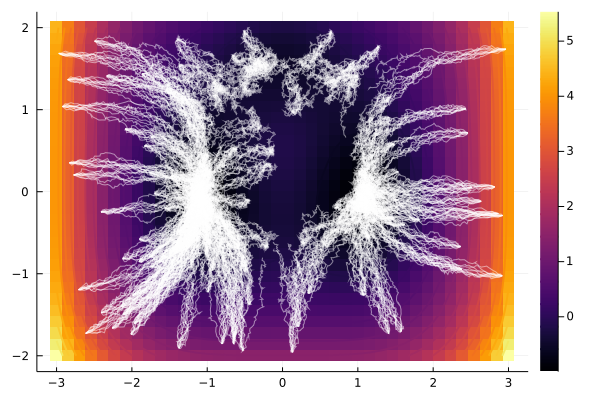

In [8]:
function eulermarujamatrajectories(x0, potential, sigma, dt, steps; branches=1)
    dim, samples = size(x0)
    xts = similar(x0, dim, steps+1, branches, samples)
    for s in 1:samples
        for b in 1:branches
            x = x0[:, s]
            xts[:, 1, b, s] = x
            for t in 2:steps+1
                g = Zygote.gradient(potential, x)[1]
                x .+= -g * dt .+ sigma * randn(dim) * sqrt(dt)
                xts[:, t, b, s] = x
            end
        end
    end
    xts = reshape(xts, dim, steps+1, branches*samples)
end

x0 = NN.sample(process, samples)
xt = eulermarujamatrajectories(x0, potential, sigma, dt, steps, branches=branches)

NN.plot(process.potential, process.box)
plot!(xt[1, :, :], xt[2, :, :], color="white", legend=false, alpha=0.5, fmt=:png)

# Learning $\chi$

In [5]:
# ISOKANN only needs start and end points, condense trajectories to this dense format
function foldbranches(x, branches)
    dim, steps, bs = size(x)
    samples = Int(bs / branches)
    reshape(x, dim, steps, branches, samples)
end

function condensetrajectories(x)
    dim, steps, branches, samples = size(x)
    xx = similar(x, dim, branches+1, samples)
    xx[:, 1, :] = x[:, 1, 1, :]
    xx[:, 2:end, :] = x[:, end, :, :]
    xx
end

trajs = condensetrajectories(foldbranches(xt, branches));

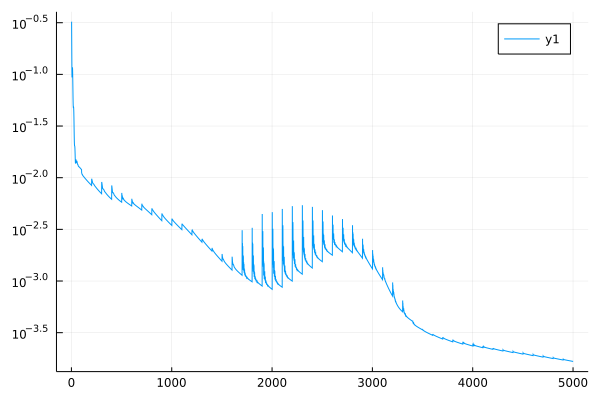

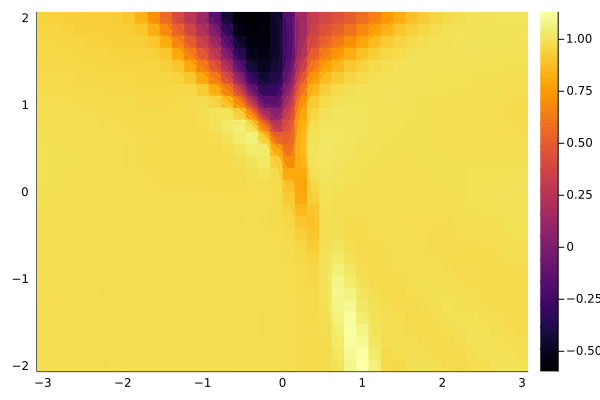

In [6]:
model, loss = isokann(data=trajs, iter=100, poweriter=50, opt=ADAM(0.01), model=mlp([10,10]))
plot(loss, yaxis=:log) |> display
NN.plot(model, process.box)

# Residual of next iteration

sqrt(mean(abs2, residual)) = 0.013005858357884557


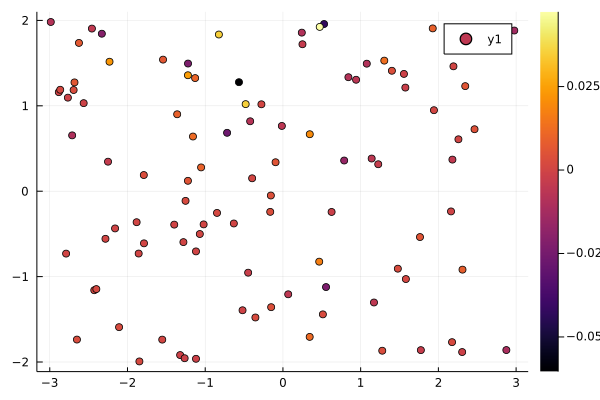

In [7]:
ys = trajs[:,2:end,:]
xs = trajs[:,1,:]
residual = koopmanexpectation(ys, model) - model(xs)
@show sqrt(mean(abs2, residual))
scatter(xs[1,:], xs[2,:], marker_z=residual)